In [2]:
import warnings

import pandas as pd

warnings.filterwarnings('ignore')

In [3]:
from chords import ChordsExtractor
from datasets_processing import guitar_set, cross_composer_dataset, process_features_ccd, get_chords_to_compare
from tonnetz import Tonnetz
from chords_masks import plt_chord_masks

In [86]:
import numpy as np
from tqdm import tqdm, trange
from sklearn.feature_extraction.text import CountVectorizer
from scipy import spatial
import os
import json
from sklearn import preprocessing
from persim import PersistenceImager
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# CHORDS

Для понимания процесса:

Аналоговый сигнал - непрерывен во времени, определен во все моменты; колебания напряжения, возникающие из-за колебаний мембраны в микрофоне

Чтобы превратить аналоговый сигнал в цифровой, проводится процесс дискретизации. Частота дискретизации sr - с какими интервалами по времени идут данные об уровне сигнала; глубина дискретизации - разрядность числа, которым описывается уровень сигнала. Для дискретизации используется функционал библиотеки librosa

Pitch classes - набор из 12 высотных классов, соответствующих высотам нот без учета октавы (сдвиг на октаву значит умножение в 2 раза)

Гармоники: при звучании ноты одновременно с ней звучат ее гармоники - ноты с кратными фундаментальной ноте частотами, но меньшей интенсивности. Первые гармоники можно найти прибавлением интервалов: h1 = n + октава, h2 = h1 + чистая квинта, h3 = h2 + чистая кварта, h4 = h3 + большая терция, h5 = h4 + малая терция и т.д.

Гармоники нужны для уточнения темплейтов аккордов. к примеру аккорд CEG (C_maj) можно в идеальном виде записать как [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]. Однако на деле звучать также будут ноты, отмеченные гармониками: [1, 0, 0.6, 0, 1, ...]

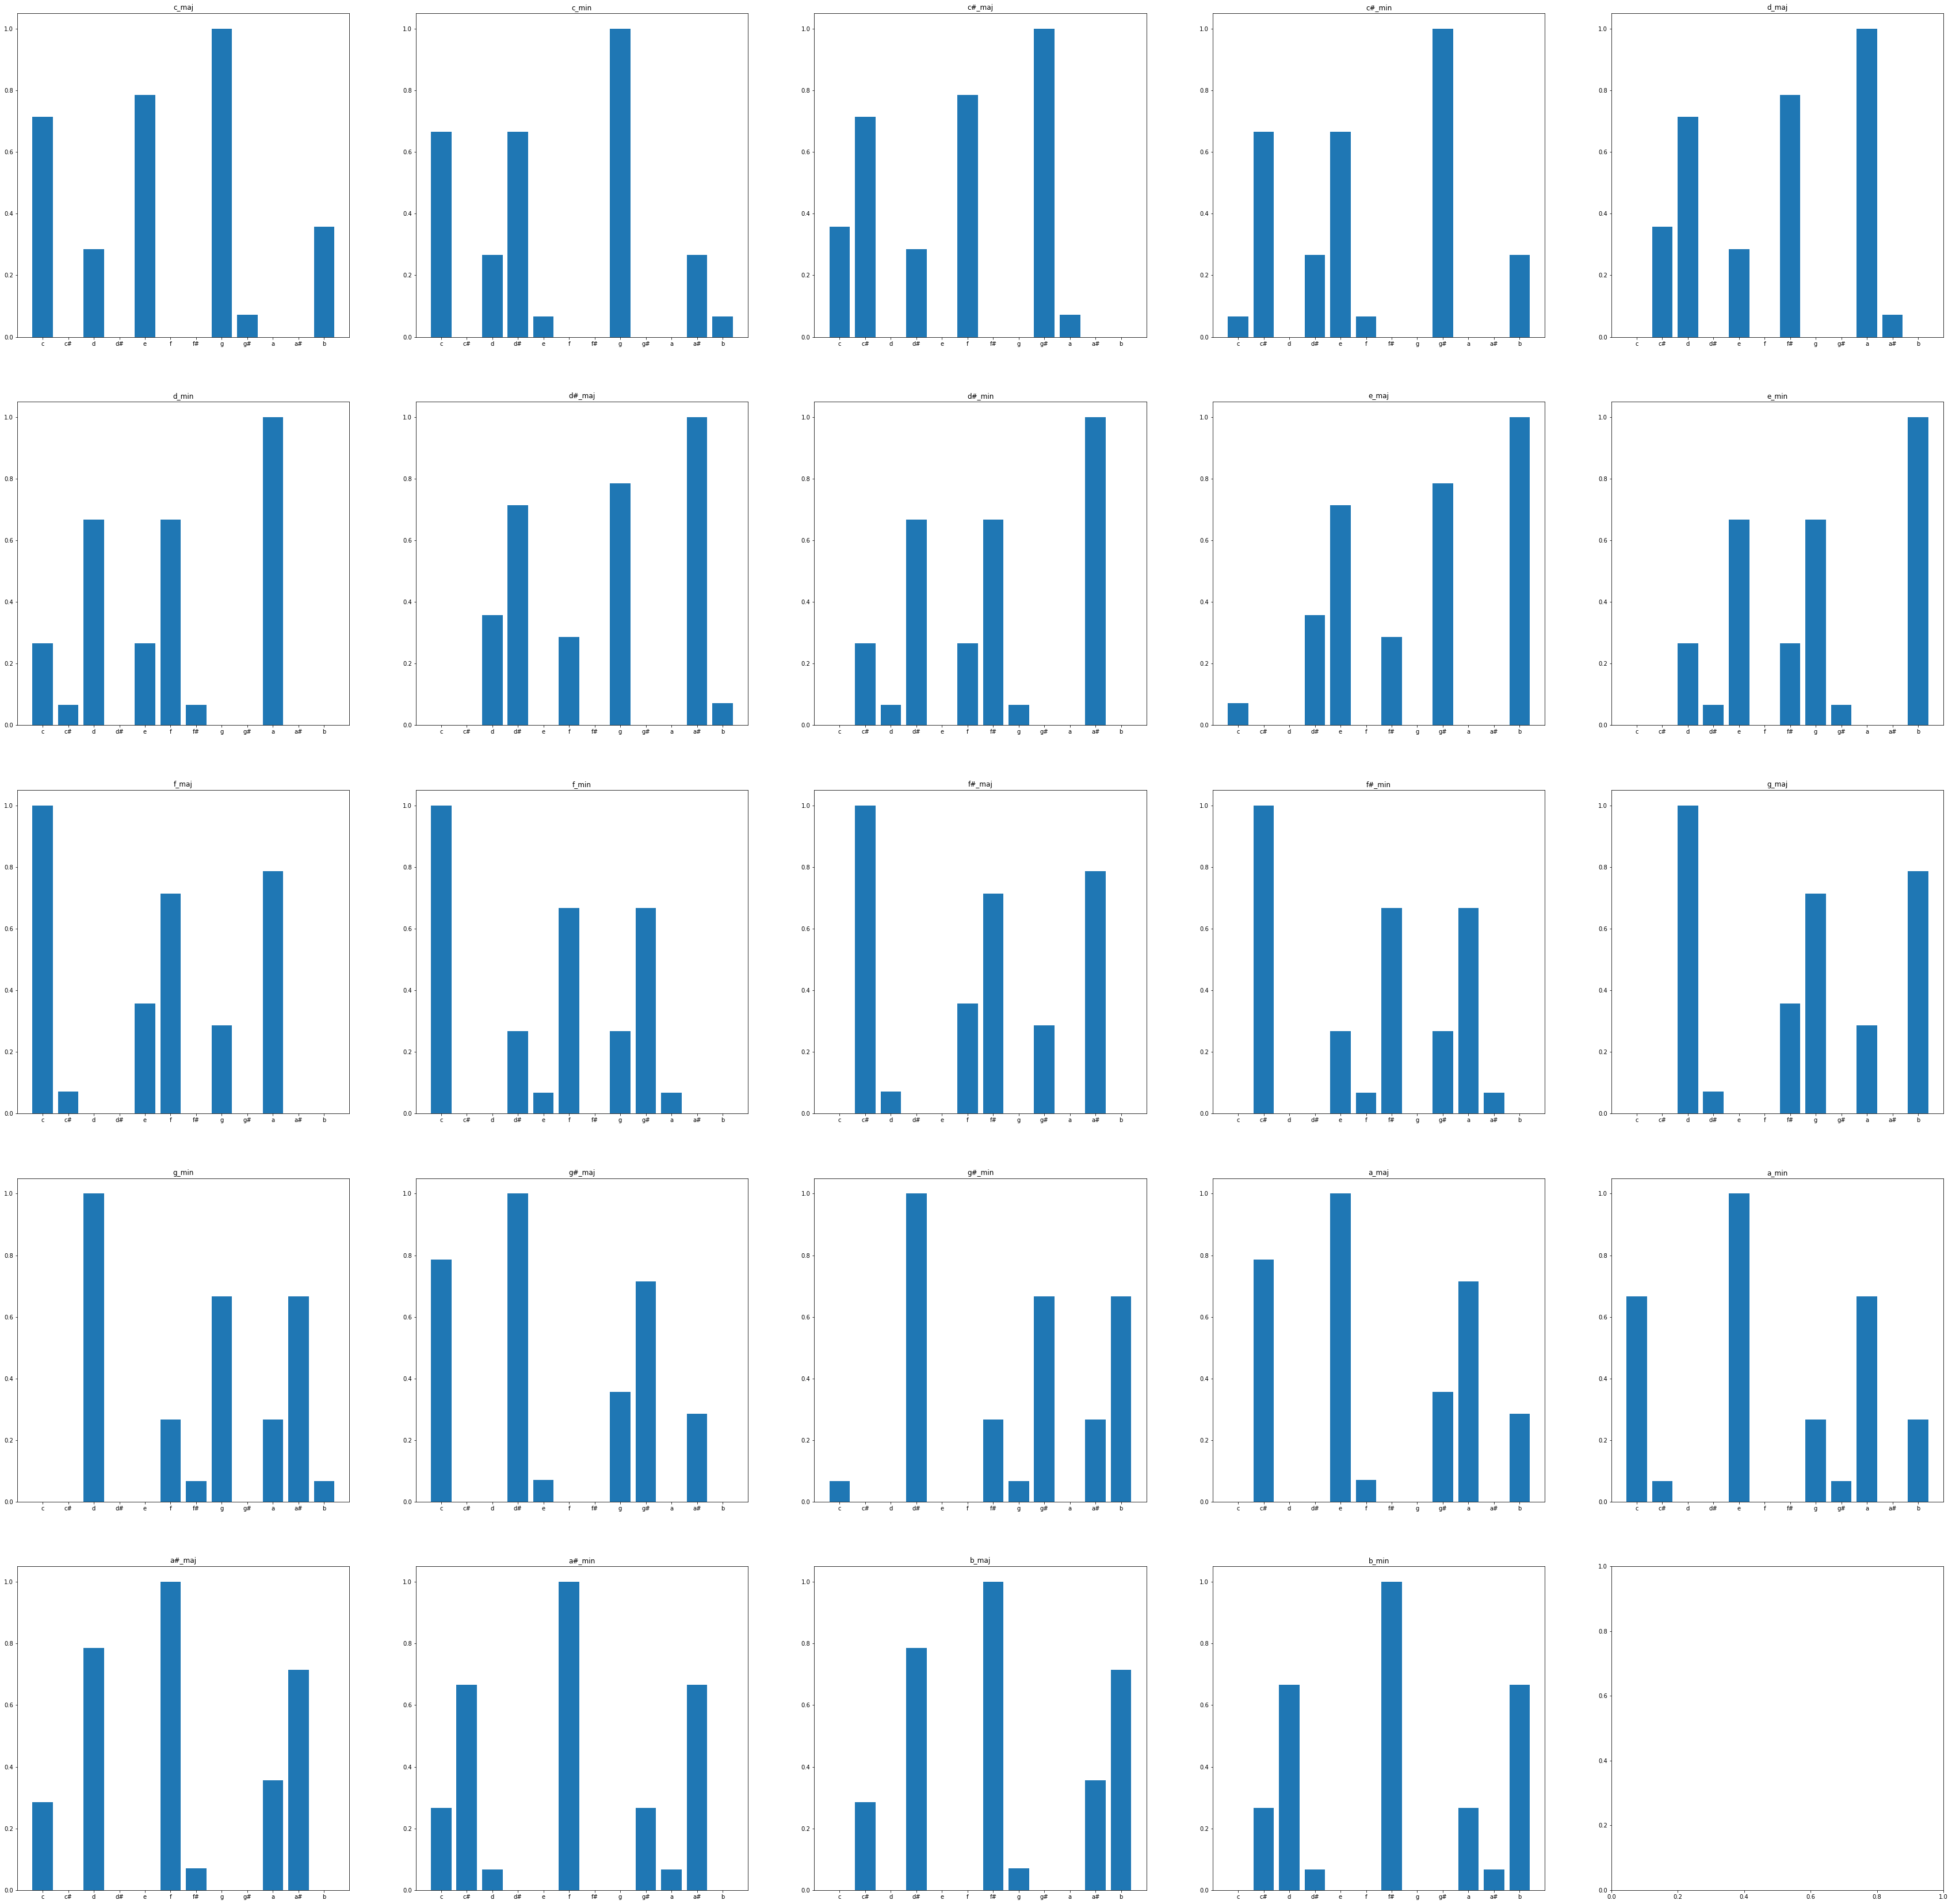

In [29]:
plt_chord_masks(5)

При процессинге композиции сначала она загружается с помощью librosa в формате временного ряда. Затем для композиции находятся точки, на которые выпадают "биения" или beats - по-простому это точки, в которых слушатель мог бы "притопывать ногой"; доказано, что именно в точках beats вероятнее всего смена аккорда. Далее для композиции находятся "вектора цветности", или PCP. Уже эти вектора сравниваются с подсчитанными масками с помощью косинусного расстояния и таким образом находится ближайший к звучащему аккорд.

In [4]:
path = "/Users/stacy-zlato/Documents/вкр/tlsp-eycte.wav"

ce = ChordsExtractor()

In [5]:
chords_tlsp, durations_tlsp = ce.process_composition(path)

In [6]:
print("Chords in The Last Shadow Puppets - Everything i've come to expect are: ", chords_tlsp)
print("Duration of first 10 chords:", durations_tlsp[:10])

Chords in The Last Shadow Puppets - Everything i've come to expect are:  ['f#_maj', 'f_maj', 'f_maj', 'c#_min', 'f_min', 'c#_maj', 'd_min', 'f_maj', 'f_maj', 'g_min', 'd_min', 'g_min', 'd_min', 'd_min', 'g_min', 'd_maj', 'd_min', 'a#_maj', 'a#_maj', 'd_min', 'd_min', 'f#_maj', 'c#_maj', 'c_maj', 'c#_maj', 'g_maj', 'f#_min', 'd_min', 'd_min', 'd_maj', 'g_min', 'g_min', 'd_min', 'a#_maj', 'a#_min', 'd#_maj', 'd#_maj', 'g#_maj', 'a#_min', 'a#_min', 'a#_min', 'g_min', 'g_min', 'g_min', 'd_min', 'g_min', 'd_min', 'g_min', 'd_min', 'a#_maj', 'a#_min', 'd#_min', 'g#_maj', 'c#_maj', 'c#_maj', 'a#_min', 'a#_min', 'f#_min', 'g_min', 'g_min', 'd_min', 'g_min', 'g_min', 'd_maj', 'd_min', 'a#_maj', 'a#_min', 'a_min', 'g#_maj', 'c#_min', 'c#_maj', 'f_min', 'f_maj', 'a_min', 'a_min', 'c_maj', 'f_maj', 'd_maj', 'a_min', 'd_maj', 'c_maj', 'd_min', 'd_min', 'c_maj', 'f_maj', 'd_maj', 'c_maj', 'b_min', 'f_maj', 'g_min', 'g_min', 'c_min', 'c_maj', 'e_maj', 'e_maj', 'd_min', 'e_maj', 'a_min', 'c_maj', 'c_m

## GuitarSet

Проверка модели распознавания аккордов на основе датасета GuitarSet

In [22]:
file_to_chord = guitar_set("/Users/stacy-zlato/Documents/вкр/PAGCD/audio_filtered/triads")

In [23]:
def process_guitar_set_audio(path, chord):
    chords_extractor = ChordsExtractor()
    chords, durations = chords_extractor.process_composition(path)
    errors_cnt = len(np.where(np.array(chords) != chord))
    chords_cnt = len(chords)
    return chords_cnt, errors_cnt

total_cnt = 0
errors_cnt = 0

for path, chord in tqdm(file_to_chord.items()):
    total, errors = process_guitar_set_audio(path, chord)
    total_cnt += total
    errors_cnt += errors

accuracy = (total_cnt - errors_cnt) / total_cnt

print("Accuracy on guitar set chord is ", accuracy)

100%|██████████| 24/24 [00:55<00:00,  2.33s/it]

Accuracy on guitar set chord is  0.9838383838383838


## Cross-composer dataset

Проверка модели распознавания аккордов на основе датасета Cross-composer dataset

In [24]:
ce = ChordsExtractor()
chroma_df, chords_df = cross_composer_dataset(
    "/Users/stacy-zlato/Documents/вкр/cross-composer_chords-chordino/chords-chordino_01_bach.csv",
    "/Users/stacy-zlato/Documents/вкр/cross-composer_chroma-nnls/chroma-nnls_01_bach.csv")

assert len(chroma_df) == len(chords_df)

chords_matrix = []
expected_matrix = []

for i in trange(len(chroma_df)):
    expected = get_chords_to_compare(chords_df[i])

    beats, chroma, durations, total_duration = process_features_ccd(chroma_df[i], chords_df[i])

    chords, time = ce.process_composition_from_dataset(chroma, beats, durations, total_duration)
    chords_matrix.append(" ".join(chords))
    expected_matrix.append(" ".join(expected))

vectorizer = CountVectorizer(stop_words=None, token_pattern=r'\w#?_\w{3}7?', analyzer='word')
vectorizer.fit(chords_matrix + expected_matrix)

X = vectorizer.transform(chords_matrix)
Y = vectorizer.transform(expected_matrix)

100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


In [25]:
similarities = [1 - spatial.distance.cosine(X.toarray()[i], Y.toarray()[i]) for i in range(len(X.toarray()))]
print("Average cosine similarity between expected chords and resulting chords is ", np.mean(similarities))

Average cosine similarity between expected chords and resulting chords is  0.9342912335127482


# SIMPLICIAL
## Frequency Tonnetz

Для полученных аккордов строится фильтрованный симплициальный комплекс. Фильтрация происходит в зависимости от
частотности аккорда в композиции: в первый комплекс фильтрации попадают только самые частотные аккорды, далее с шагом
фильтрации в 0.005 рассматриваются все менее и менее частотные, пока не получим комплекс, содержащий в себе все аккорды.

Аналогично рассматриваются симплексы меньших размерностей: 0-d симплексы, отвечающие за PC, и 1-d симплексы, отвечающие
за интервалы. Их частотности вычисляются также относительно общего числа аккордов

In [7]:
tonnetz = Tonnetz(tonnetz_type="frequency")
filtration = tonnetz.build_filtration(chords=chords_tlsp, durations=durations_tlsp)

In [8]:
print("Simplices in filtration:", filtration.simplices())
print("Last index of filtration: ", filtration.getIndex())

Simplices in filtration: ['a', 'c', 'e', 'f', 'd', 'g', 'a#', 'b', 'g#', 'c#', 'd#', 'f#', 'ce', 'af', 'ad', 'df', 'ac', 'ae', 'eg', 'cg', 'cf', 'dg', 'bg', 'a#d', 'a#g', 'be', 'fg#', 'cg#', 'c#f', 'd#g', 'af#', 'a#f', 'cd#', 'df#', 'a#c#', 'bd', 'c#g#', 'eg#', 'bg#', 'a#d#', 'd#g#', 'ac#', 'a#f#', 'bd#', 'bf#', 'c#e', 'c#f#', 'd#f#', 'adf', 'ace', 'ceg', 'a#dg', 'beg', 'acf', 'cfg#', 'adf#', 'cd#g', 'a#c#f', 'bdg', 'c#fg#', 'beg#', 'a#df', 'a#d#g', 'cd#g#', 'ac#e', 'ac#f#', 'a#c#f#', 'a#d#f#', 'bdf#', 'bd#f#', 'bd#g#', 'c#eg#']
Last index of filtration:  114


Диаграммы устойчивости строятся на основе граничного оператора (= boundary operator, матрица границ).

К столбцам матрицы применяется алгоритм Гаусса (для приведения матрицы к ступенчатому виду).

Последовательно рассматриваются столбцы слева направо, low(x) – номер строки самого нижнего ненулевого элемента в столбце x

Если слева от текущего столбца x найдётся столбец y, что low(x) = low(y), то он, домноженный на соответствующий коэффициент, вычитается из x, тем самым low(x) уменьшается 

Это повторяется для текущего x, до тех пор, пока находится столбец y

Граничный оператор показывает, какие (k-1)-симплексы являются гранями k-симплексов. Это матрица, в которой колонки обозначают k-симплексы, строки - (k-1)-симплексы. Так, в матрице ниже 1 на пересечении 1 и 13 симплексов означает, что 1 входит в симплекс 13 как грань.

\begin{equation} 
\begin{bmatrix}
& | & 13 & 24 & 12 & 34 & 14 & 23 \\
\hline
1 & | & 1 & 0 & 1 & 0 & 1 & 0 \\
2 & | & 0 & 1 & 1 & 0 & 0 & 1 \\
3 & | & 1 & 0 & 0 & 1 & 0 & 1 \\
4 & | & 0 & 1 & 0 & 1 & 1 & 0
\end{bmatrix}
\end{equation}

In [11]:
persistence_diagram = tonnetz.compute_persistence(k=2)
persistence_diagram

array([[ 58,  60],
       [ 86,  91],
       [ 97,  98],
       [ 97, 100],
       [ 95, 105],
       [104, 105],
       [109, 110],
       [109, 113]])

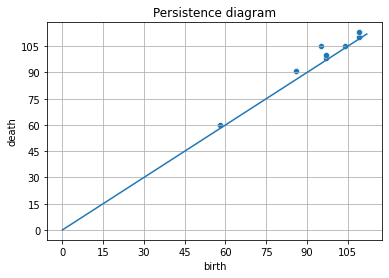

In [12]:
tonnetz.plt_persistence()

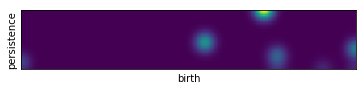

In [13]:
tonnetz.plot_persistence_image()

## Trajectories

Тоннец траектория - это граф в Тоннец-пространстве, показывающий последовательность аккордов во времени. Веса элементов в графе -
их длительность звучания; вершины, ребра и более сложные структуры задаются аналогично прошлому подходу.

Для каждого аккорда находятся координаты в заданном Тоннец-пространстве (например, Т(3,4,5)). Отсчет начинается от первого
"квадрата" плоскости, где (0,0) отвечает за высотный класс C. Сектор 3 х 4 с началом
в точке (0,0) задает все 12 высотных классов.

In [12]:
tonnetz_traj = Tonnetz(tonnetz_type="trajectory", pixel_size=5)
traj_filtration = tonnetz_traj.build_filtration(chords=chords_tlsp, durations=durations_tlsp)

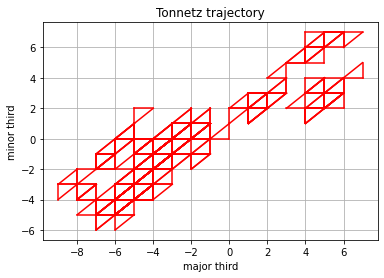

In [13]:
tonnetz_traj.plt_trajectory()

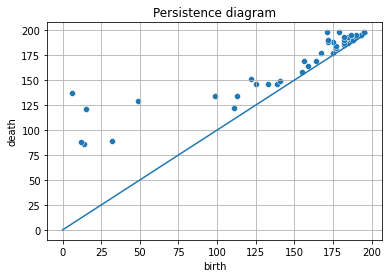

In [14]:
tonnetz_traj.compute_persistence(k=1)
tonnetz_traj.plt_persistence()

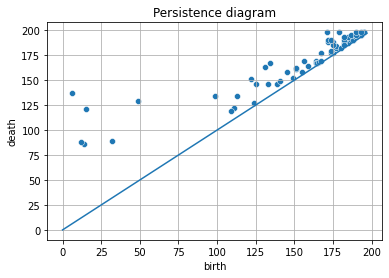

In [15]:
tonnetz_traj.compute_persistence_merged()
tonnetz_traj.plt_persistence()

In [14]:
print("Filtration from tonnetz traj with number of simplices: ", len(traj_filtration.simplices()))
print("Last index of filtration: ", traj_filtration.getIndex())

Filtration from tonnetz traj with number of simplices:  318
Last index of filtration:  199


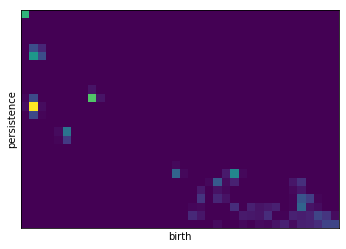

In [16]:
tonnetz_traj.plot_persistence_image()

Traceback (most recent call last):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_utils.py", line 69, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


<AxesSubplot:xlabel='birth', ylabel='persistence'>

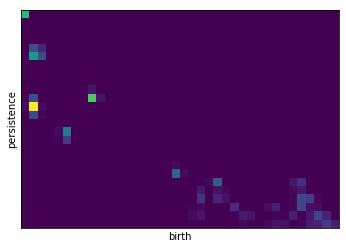

In [31]:
from persim import PersistenceImager

p = PersistenceImager(pixel_size=5)

p.plot_image(p.fit_transform(tonnetz_traj._persistence_diagram))

# EXPERIMENTS

## Topological representation

### GTZAN dataset

Модели определения жанра композиций на основе датасета GTZAN

1. Предобработка датасета

In [17]:
path = "/Users/stacy-zlato/Documents/вкр/GTZAN"

genres = list(filter(lambda x: x != '.DS_Store', os.listdir(path)))

In [117]:
ce = ChordsExtractor()

def process_path(path):
    chords, durations = ce.process_composition(path)
    tonnetz_trajectory = Tonnetz(tonnetz_type="trajectory", pixel_size=5)
    tonnetz_trajectory.build_filtration(chords, durations)

    return tonnetz_trajectory.compute_persistence_merged()

Проверка бинарной классификации (жанры - классика и поп-музыка)

In [76]:
genres = ["classical", "pop"]

In [ ]:
data_lst = []
for genre in genres:
    genre_path = path + "/" + genre
    compositions = [[genre_path + "/" + x, genre] for x in os.listdir(genre_path)]
    data_lst.extend(compositions)
    
for composition in tqdm(data_lst):
    pers_diagram = process_path(composition[0])
    composition.append(pers_diagram)    

In [22]:
data_lst[:10]

[['/Users/stacy-zlato/Documents/вкр/GTZAN/classical/classical.00097.au',
  'classical',
  array([[  1,  29],
         [ 42,  71],
         [149, 166],
         [166, 171],
         [138, 172],
         [189, 195],
         [ 82,  99],
         [177, 183]])],
 ['/Users/stacy-zlato/Documents/вкр/GTZAN/classical/classical.00064.au',
  'classical',
  array([[ 66,  77],
         [109, 132],
         [167, 177],
         [181, 191]])],
 ['/Users/stacy-zlato/Documents/вкр/GTZAN/classical/classical.00035.au',
  'classical',
  array([[ 37,  85],
         [ 52, 100],
         [142, 153],
         [ 98, 158],
         [147, 158],
         [153, 158],
         [175, 180],
         [175, 180],
         [179, 190],
         [185, 190],
         [166, 195],
         [190, 195],
         [185, 195],
         [105, 122],
         [169, 174],
         [162, 179],
         [174, 179],
         [179, 184],
         [190, 195]])],
 ['/Users/stacy-zlato/Documents/вкр/GTZAN/classical/classical.00001.au',
  '

In [23]:
data = [[x[0], x[1], x[2].tolist()] for x in data_lst]

In [24]:
with open("/Users/stacy-zlato/Documents/вкр/data_binary_5px.json", "w") as f:
    json.dump(data, f)

In [73]:
with open('/Users/stacy-zlato/Documents/вкр/data_binary_5px.json') as f:
    data = json.load(f)

Пустые диаграммы устойчивости не несут никакой полезной информации - отфильтруем их

In [74]:
data_filtered = list(filter(lambda x: x[2] != [], data))
persistence_diagrams = [x[2] for x in data_filtered]

Кодируем ожидаемые значения с помощью LabelEncoder

In [77]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(genres)

LabelEncoder()

Вычислим persistence images с размером пикселей 5 (от размера пикселя зависит итоговое разрешение изображения; при
малых значениях матрица становится слишком разреженной)

In [78]:
pimgr = PersistenceImager(pixel_size=5)
p_imgs = pimgr.fit_transform(persistence_diagrams, skew=True)

In [79]:
len(p_imgs)

200

100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


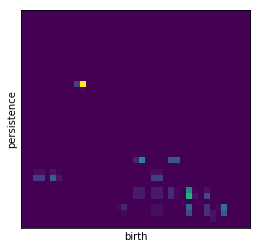

In [80]:
for i in trange(len(data_filtered)):
    id = "{}_{}.jpg".format(i, label_encoder.transform([data_filtered[i][1]])[0])
    pimgr.plot_image(p_imgs[i], out_file="/Users/stacy-zlato/Documents/вкр/gtzan_imgs/binary/5px/" + id)

Векторизуем изображения, преобразовав в список пикселей

In [81]:
X_data = [[pixel for row in img for pixel in row] for img in p_imgs]

In [82]:
Y_data = label_encoder.transform([x[1] for x in data_filtered])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                    stratify=Y_data,
                                                    test_size=0.3)

2. В качестве первой модели рассмотрим Random Forest Classifier

In [36]:
rf = RandomForestClassifier(n_estimators=100)

rf.fit(X_train, y_train)

RandomForestClassifier()

In [37]:
y_predicted_train = rf.predict(X_train)
score = accuracy_score(y_train, y_predicted_train)
score

1.0

In [38]:
y_predicted_test = rf.predict(X_test)
score_test = accuracy_score(y_test, y_predicted_test)
score_test

0.6

Попробуем улучшить результат, подобрав параметры модели с помощью кросс-валидации

In [39]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10,
                               random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [43]:
predicted_train = rf_random.best_estimator_.predict(X_train)
accuracy_score(y_train, predicted_train)

0.9785714285714285

In [44]:
predicted_test = rf_random.best_estimator_.predict(X_test)
accuracy_score(y_test, predicted_test)

0.5833333333333334

3. Попробуем дерево решений в качестве классификатора

In [45]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)


In [47]:
predicted_test = clf.predict(X_test)
accuracy_score(y_test, predicted_test)

0.5666666666666667

In [88]:
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [89]:
clf = tree.DecisionTreeClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10,
                               random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=10)

In [90]:
predicted_train = rf_random.best_estimator_.predict(X_train)
accuracy_score(y_train, predicted_train)

0.9428571428571428

In [91]:
predicted_test = rf_random.best_estimator_.predict(X_test)
accuracy_score(y_test, predicted_test)

0.65

4. ... и SVC

In [48]:
from sklearn.svm import SVC

svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [49]:
predicted_train = svc.predict(X_train)
accuracy_score(y_train, predicted_train)

0.9785714285714285

In [50]:
predicted_test = svc.predict(X_test)
accuracy_score(y_test, predicted_test)

0.6

In [53]:
C = [x for x in np.linspace(0.1, 5, 20)]
kernel=["linear", "poly", "rbf", "sigmoid"]
degree = [x for x in range(1, 5)]
gamma = ["scale", "auto"]
coef0 = [x for x in np.linspace(0.0, 10, 20)]
shrinking = [True, False]
probability = [True, False]
decision_function_shape = ["ovo", "ovr"]

random_grid = {'C': C,
               'kernel': kernel,
               'degree': degree,
               'gamma': gamma,
               'coef0': coef0,
               'shrinking': shrinking,
               'probability': probability,
               'decision_function_shape': decision_function_shape}

In [54]:
svc = SVC()
rf_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10,
                               random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.35789473684210527,
                                              0.6157894736842106,
                                              0.8736842105263158,
                                              1.1315789473684212,
                                              1.3894736842105266,
                                              1.6473684210526318,
                                              1.905263157894737,
                                              2.1631578947368424,
                                              2.421052631578948,
                                              2.678947368421053,
                                              2.936842105263158,
                                              3.1947368421052635,
                                              3.452631578947369,
                                              3.71052631578947...
                                                  5.789473684210526,
                                                  6.315789473684211,
                                                  6.842105263157895,
                                                  7.368421052631579,
                                                  7.894736842105263,
                                                  8.421052631578947,
                                                  8.947368421052632,
                                                  9.473684210526315, 10.0],
                                        'decision_function_shape': ['ovo',
                                                                    'ovr'],
                                        'degree': [1, 2, 3, 4],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True, False],
                                        'shrinking': [True, False]},
                   random_state=42, verbose=10)

In [56]:
predicted_train = rf_random.best_estimator_.predict(X_train)
accuracy_score(y_train, predicted_train)

1.0

In [57]:
predicted_test = rf_random.best_estimator_.predict(X_test)
accuracy_score(y_test, predicted_test)

0.6333333333333333

5. И попробуем классифицировать PersistenceImages как изображения с помощью CNN

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [59]:
import re
import shutil

base_path = "/Users/stacy-zlato/Documents/вкр/gtzan_imgs/binary/5px"

images_files = list(map(lambda x: base_path + "/" + x, filter(lambda x: x != '.DS_Store', os.listdir(base_path))))

In [60]:
name_mathcer = re.search(r"(.*?\/)(\d+_(\d).jpg)$", images_files[0])
name_mathcer.groups()

('/Users/stacy-zlato/Documents/вкр/gtzan_imgs/binary/5px/', '93_0.jpg', '0')

In [61]:
regex = r".*?\d+_(\d).jpg$"

y_data = []

for img_file in images_files:
    matcher = re.search(regex, img_file)
    if matcher:
        y_data.append(int(matcher.group(1)))
    else:
        print(img_file)

x_train, x_test, y_train, y_test = train_test_split(images_files, y_data)

In [62]:
def move_img_to_folder(img_path, folder):
    if not os.path.isfile(img_path):
        return
    name_mathcer = re.search(r"(.*?\/)(\d+_(\d).jpg)$", img_path)
    if name_mathcer:
        dir = name_mathcer.group(1) + folder + "/"
        if not os.path.isdir(dir):
            os.mkdir(dir)
        dir += label_encoder.inverse_transform([int(name_mathcer.group(3))])[0] + "/"
        if not os.path.isdir(dir):
            os.mkdir(dir)
        new_path = dir + \
                   name_mathcer.group(2)
        shutil.move(img_path, new_path)
        return new_path
    print(img_path)

for i in trange(len(x_train)):
    new_path = move_img_to_folder(x_train[i], "train")
    x_train[i] = new_path

for i in trange(len(x_test)):
    new_path = move_img_to_folder(x_test[i], "test")
    x_test[i] = new_path

100%|██████████| 50/50 [00:00<00:00, 1148.27it/s]


In [63]:
dataset = ImageFolder(base_path + "/train/", transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

test_dataset = ImageFolder(base_path + "/test/", transform=transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

Label : classical


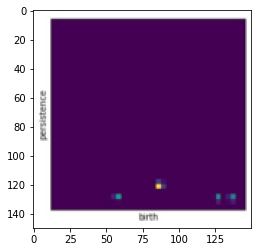

In [64]:
import matplotlib.pyplot as plt
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*dataset[10])

In [65]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 100
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 50
Length of Validation Data : 100


In [66]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [67]:
class CompositionsClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,2)
        )

    def forward(self, xb):
        return self.network(xb)

In [68]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in trange(epochs):

        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

(здесь был красивый результат обучения по эпохам, но перезапускать обучение ради него мне не хочется)

In [ ]:
model = CompositionsClassification()
num_epochs = 100
opt_func = torch.optim.SGD
lr = 0.005

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [71]:
dataiter_train = iter(val_dl)
images, labels = dataiter_train.next()

outputs = model(images)

In [72]:
_, predicted = torch.max(outputs, 1)
accuracy_score(labels, predicted)

0.48

6. Попробуем также еще один подход с еще одним слоем предобработки: построим матрицу расстояний для train-сета и обучим
модель на ней

In [102]:
diags = [np.array(d[2]) for d in data_filtered]

In [103]:
encoder = preprocessing.LabelEncoder()
labels = np.array(encoder.fit_transform([d[1] for d in data_filtered]))

In [104]:
pimgr = PersistenceImager(pixel_size=5)
p_imgs = pimgr.fit_transform(diags, skew=True)

In [105]:
imgs_flatten = [[pixel for row in img for pixel in row]  for img in p_imgs]

In [106]:
x_train, x_test, y_train, y_test = train_test_split(imgs_flatten, labels)

In [107]:
from scipy.spatial import distance_matrix

X_train_distance = distance_matrix(x_train, x_train)
X_test_distance = distance_matrix(x_test, x_train)

In [111]:
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [112]:
clf = tree.DecisionTreeClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10,
                               random_state=42, n_jobs = -1)
rf_random.fit(X_train_distance, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=10)

In [113]:
accuracy_score(y_train, rf_random.best_estimator_.predict(X_train_distance))

0.8666666666666667

In [114]:
accuracy_score(y_test, rf_random.best_estimator_.predict(X_test_distance))

0.64

Итого, лучшие результаты показал Decision Tree Classifier - 65% на бинарной классификации. Попробуем обучить его на полном
датасете

In [115]:
path = "/Users/stacy-zlato/Documents/вкр/GTZAN"
genres = list(filter(lambda x: x != '.DS_Store', os.listdir(path)))

In [118]:
data_lst = []
for genre in genres:
    genre_path = path + "/" + genre
    compositions = [[genre_path + "/" + x, genre] for x in os.listdir(genre_path)]
    data_lst.extend(compositions)

for composition in tqdm(data_lst):
    pers_diagram = process_path(composition[0])
    composition.append(pers_diagram)


100%|██████████| 1000/1000 [34:10<00:00,  2.05s/it]


In [120]:
data = [[x[0], x[1], x[2].tolist()] for x in data_lst]

In [121]:
with open("/Users/stacy-zlato/Documents/вкр/data_full_5px.json", "w") as f:
    json.dump(data, f)

In [122]:
with open('/Users/stacy-zlato/Documents/вкр/data_full_5px.json') as f:
    data = json.load(f)

In [123]:
data_filtered = list(filter(lambda x: x[2] != [], data))
persistence_diagrams = [x[2] for x in data_filtered]

In [124]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(genres)

LabelEncoder()

In [125]:
pimgr = PersistenceImager(pixel_size=5)
p_imgs = pimgr.fit_transform(persistence_diagrams, skew=True)

In [126]:
X_data = [[pixel for row in img for pixel in row] for img in p_imgs]

In [127]:
Y_data = label_encoder.transform([x[1] for x in data_filtered])

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                    stratify=Y_data,
                                                    test_size=0.3)

In [129]:
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [130]:
clf = tree.DecisionTreeClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10,
                               random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, verbose=10)

In [131]:
predicted_train = rf_random.best_estimator_.predict(X_train)
accuracy_score(y_train, predicted_train)

0.9985714285714286

In [132]:
predicted_test = rf_random.best_estimator_.predict(X_test)
accuracy_score(y_test, predicted_test)

0.13333333333333333

## Emotional classification

На датасете osfstorage-archive. Из-за особенностей содержащихся в датасете композиций проблемы начались
еще на этапе получения аккордов и построения PD - вышло много диаграмм с тривиальными устойчивостями

In [5]:
path_emotional_ds = "/Users/stacy-zlato/Documents/вкр/osfstorage-archive/"

df = pd.read_csv(path_emotional_ds + "mean_ratings_set1.csv")

y_data_labels = df["TARGET"]

In [6]:
tracks = sorted(list(map(lambda x: path_emotional_ds + "Set1/" + x, os.listdir(path_emotional_ds + "Set1"))))[1:]

tracks[:10]

['/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/001.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/002.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/003.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/004.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/005.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/006.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/007.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/008.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/009.mp3',
 '/Users/stacy-zlato/Documents/вкр/osfstorage-archive/Set1/010.mp3']

In [7]:
emotions_le = preprocessing.LabelEncoder()
y_data = emotions_le.fit_transform(y_data_labels)

y_data[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
process_path(tracks[4])

array([], dtype=float64)

In [9]:
data_lst = []

for track in tqdm(tracks):
    pers_diagram = process_path(track)
    data_lst.append(pers_diagram)

100%|██████████| 360/360 [08:57<00:00,  1.49s/it]


In [10]:
data_lst[:10]

[array([[ 47,  55],
        [ 55,  63],
        [130, 138],
        [192, 193],
        [185, 193],
        [177, 200],
        [ 71,  79]]),
 array([[140, 154],
        [ 42, 163],
        [155, 170],
        [156, 170],
        [153, 184],
        [ 41, 186]]),
 array([[ 15,  44],
        [115, 129],
        [143, 157],
        [157, 171],
        [142, 172],
        [157, 186]]),
 array([[ 66,  89],
        [114, 136],
        [122, 145],
        [130, 152],
        [128, 164],
        [110, 178],
        [167, 178],
        [178, 189],
        [105, 189]]),
 array([], dtype=float64),
 array([[  5,  59],
        [113, 127],
        [126, 142],
        [128, 142],
        [127, 142],
        [113, 143],
        [132, 144],
        [116, 146],
        [ 98, 186],
        [186, 187],
        [147, 159]]),
 array([[ 16,  79],
        [ 27,  87],
        [ 15,  95],
        [106, 121],
        [ 88, 122],
        [ 89, 122],
        [135, 136],
        [149, 151],
        [118, 152],
   

In [13]:
empty_diagrams = []
for i in range(len(data_lst)):
    if len(data_lst[i]) == 0:
        empty_diagrams.append(i)


In [15]:
y_data = np.delete(y_data, empty_diagrams)
len(y_data)

305

In [16]:
x_data = np.delete(data_lst, empty_diagrams)
len(x_data)

305

In [17]:
pimgr = PersistenceImager(pixel_size=5)
p_imgs = pimgr.fit_transform(x_data, skew=True)

In [19]:
X_data = [[pixel for row in img for pixel in row] for img in p_imgs]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

In [20]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [22]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10,
                               random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=10)

In [24]:
predicted_train = rf_random.best_estimator_.predict(X_train)
accuracy_score(y_train, predicted_train)


0.9605263157894737

In [26]:
predicted_test = rf_random.best_estimator_.predict(X_test)
accuracy_score(y_test, predicted_test)

0.1038961038961039

Это явно неподходящий способ классификации для определения эмоций музыки )